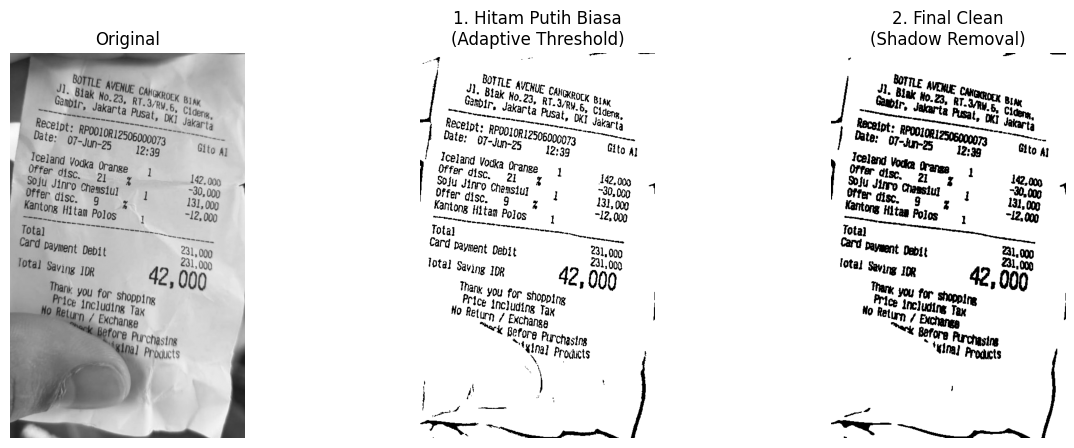

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Sedang memproses OCR (Mohon tunggu sebentar)...


   1. HASIL OCR (HITAM PUTIH BIASA)   
JI.
Ko.23,
6,
DKz
12:39
A]
Jinro
21
14z,0c
disc:
~0,O00
131,00
~IZ,00
Layment
231,000
231,000
IDR
42,000
You for
Ho
Tax
BOTTLE
AVENUE
cavckrock
Blak
Gambir,
BIAK
RT.J/rw.
Jakarta
Cldena.
Fusat,
Recelpt :
Jakarta
RPOO1OR12506000073
Date:
07-Jun-25
Gito
Iceland
Vodka
Orange
Offer
disc
Soju
Chanstu]
offer
Kantonz
Hitam
Polos
Total
Card
Deblt
Iotal
Saving
Thank
shopping
Price
Inc}uding
Return
Exchange
aherk
Berore
Purchasins
~{xlna]
Prochkcts



      2. HASIL OCR (FINAL CLEAN)      
Ji;
ma
1259
Glto MI
Ofter
21
Jizm
9
131,0@
Polcs
~E0
Total
Dawent
83
O
0
ID
42,000
YTv It
No
Tex
BOTTLE
MHHE
Cmictrok
Blek
Golr,
BIM
RT_Jrr &
Jakarta
Clon_
pal;
Recelpt:
Jakerta
RRooicrizsoewoTJ
Date:
07-Jn--2
Icled
Vr
02ra
disc:
Sju
Jitro
Gasstul
30
otter
dicc:
Kantors
Hitas
Card
Dablt
Iotal
Savlis
Trerk
soplr
Frice
Jnclding
Retumn
Exchatza
Betore
ardtaslna
'xlral
Fredcts


In [ ]:
import cv2
import numpy as np
import easyocr
from matplotlib import pyplot as plt
import os

# Load Gambar (sekali saja di awal)
img_path = "../../dataset/test/img/abel.jpg"
if os.path.exists(img_path):
    original_img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
else:
    print("Gambar tidak ditemukan")
    gray_img = None

# ===== FUNGSI TUNING YANG FLEKSIBEL =====
def tuning_lab(image, blur_kernel=21, denoise_h=10, erode_iter=1, upscale=False):
    """
    image       : Gambar grayscale input
    blur_kernel : Ukuran area untuk deteksi bayangan (Ganjil: 21, 31, 41...)
    denoise_h   : Kekuatan pembersih noise (10, 15, 20...)
    erode_iter  : Berapa kali huruf ditebalkan (0, 1, 2)
    upscale     : Perbesar gambar 2x lipat (Bagus untuk struk kecil)
    """
    if image is None: return
    
    processing_img = image.copy()

    # [OPSIONAL] Upscaling: Seringkali membantu OCR membaca huruf kecil
    if upscale:
        processing_img = cv2.resize(processing_img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)

    # 1. Shadow Removal (Tuning: blur_kernel)
    dilated = cv2.dilate(processing_img, np.ones((7, 7), np.uint8))
    bg_blur = cv2.medianBlur(dilated, blur_kernel) # <--- DI SINI TUNINGNYA
    diff = 255 - cv2.absdiff(processing_img, bg_blur)
    norm = cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    # 2. Thresholding (Otsu biasanya sudah cukup stabil)
    _, binary = cv2.threshold(norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 3. Denoising (Tuning: denoise_h)
    # Parameter h (denoise_h) menentukan kekuatan pembersihan
    clean = cv2.fastNlMeansDenoising(binary, None, h=denoise_h, templateWindowSize=7, searchWindowSize=21)
    
    # 4. Penebalan (Tuning: erode_iter)
    final = clean
    if erode_iter > 0:
        kernel = np.ones((2, 2), np.uint8)
        final = cv2.erode(clean, kernel, iterations=erode_iter)

    # Tampilkan Hasil
    plt.figure(figsize=(10, 6))
    plt.imshow(final, cmap='gray')
    plt.title(f"Blur={blur_kernel} | Denoise={denoise_h} | Tebal={erode_iter} | Upscale={upscale}")
    plt.axis('off')
    plt.show()
    
    return final

# ===== AREA EKSPERIMEN (GANTI ANGKA DISINI) =====

if gray_img is not None:
    # Percobaan 1: Settingan Default
    print("--- Percobaan 1: Default ---")
    res1 = tuning_lab(gray_img, blur_kernel=21, denoise_h=10, erode_iter=1, upscale=False)

    # Percobaan 2: Lebih Bersih (Bayangan Bandel & Noise Banyak)
    print("--- Percobaan 2: High Clean (Untuk bayangan gelap) ---")
    res2 = tuning_lab(gray_img, blur_kernel=51, denoise_h=20, erode_iter=1, upscale=False)
    
    # Percobaan 3: Mode Detail (Agar koma/titik tidak hilang) + Upscale
    print("--- Percobaan 3: Detail Mode + Upscale (Rekomendasi Struk Kecil) ---")
    # Blur kecil, Denoise kecil agar koma aman, tapi di-upscale biar jelas
    res3 = tuning_lab(gray_img, blur_kernel=21, denoise_h=5, erode_iter=0, upscale=True)
    
    # Coba OCR pada hasil terbaik (Misal hasil 3)
    print("OCR pada Percobaan 3:")
    reader = easyocr.Reader(['en'])
    print("\n".join(reader.readtext(res3, detail=0)))